## Carefull, very much work in progress
Currently, uses a single items
This may not work
Other ideas:
Using multiple items

Uses scaler, may not be working correctly.

In [2]:
%load_ext dotenv
%reload_ext dotenv
%dotenv

In [3]:
import mlflow
from darts.models import XGBModel
import pandas as pd
import numpy as np

In [5]:
# Download source data from s3
from gw2ml.data.s3_sync import download_folder_from_s3

import os

datapath = os.path.join(os.getenv('DATA_PATH'), 'train_xgboost')
os.makedirs(datapath, exist_ok=True)


download_folder_from_s3(s3_folder_prefix='datasources/gw2/raw/1762686861', local_folder=datapath)
df = pd.read_csv(f'{datapath}/Copper Ore.csv', delimiter=";")


Source: ost-s3/datasources/gw2/raw/1762686861
Target: /home/lukas/Documents/Github/casml4se-stonkswagen/data/train_xgboost

Found 60 files to download

⊘ +1 Agony Infusion.csv (already exists, ETag matches)
⊘ Auric Sliver.csv (already exists, ETag matches)
⊘ Bag of Coffee Beans.csv (already exists, ETag matches)
⊘ Bag of Sugar.csv (already exists, ETag matches)
⊘ Black Lion Chest.csv (already exists, ETag matches)
⊘ Bowl of Candy Corn Custard.csv (already exists, ETag matches)
⊘ Choya Spine.csv (already exists, ETag matches)
⊘ Congealed Putrescence.csv (already exists, ETag matches)
⊘ Copper Ore.csv (already exists, ETag matches)
⊘ Cup of Spiced Apple Cider.csv (already exists, ETag matches)
⊘ Elder Wood Log.csv (already exists, ETag matches)
⊘ Eye of Kormir.csv (already exists, ETag matches)
⊘ Flawless Snowflake.csv (already exists, ETag matches)
⊘ Fried Golden Dumpling.csv (already exists, ETag matches)
⊘ Glass of Buttered Spirits.csv (already exists, ETag matches)
⊘ Glob of Ectoplas

The provided DatetimeIndex was associated with a timezone (tz), which is currently not supported. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


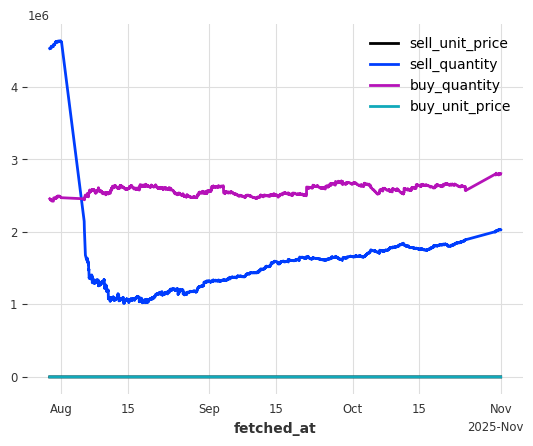

In [4]:
from darts import TimeSeries
#value_cols = ["buy_unit_price","sell_quantity", "sell_unit_price", "buy_quantity"]

value_cols = ["sell_unit_price", "sell_quantity", "buy_quantity", "buy_unit_price"]

tsdf = df[value_cols + ['fetched_at']].copy()
# series = TimeSeries.from_dataframe(df, time_col="fetched_at")

# Convert to datetime and set as index
tsdf['fetched_at'] = pd.to_datetime(tsdf['fetched_at'])
tsdf = tsdf.set_index('fetched_at')

#value_cols = ["buy_unit_price"]  #ARIMA only univariate !

# Resample to exact 5-minute intervals, forward-filling missing values
tsdf_resampled = tsdf[value_cols].resample('5min').mean().interpolate(method='linear')

# Create TimeSeries (no need for fill_missing_dates now)
series = TimeSeries.from_dataframe(tsdf_resampled, value_cols=value_cols)
series.plot();


<Axes: xlabel='fetched_at'>

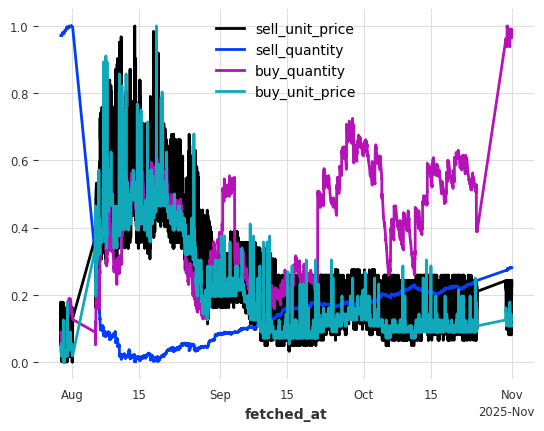

In [7]:
# Scaling the data
from darts.dataprocessing.transformers import Scaler
scaler = Scaler()
series_scaled = scaler.fit_transform(series)
series_scaled.plot()

<Axes: xlabel='fetched_at'>

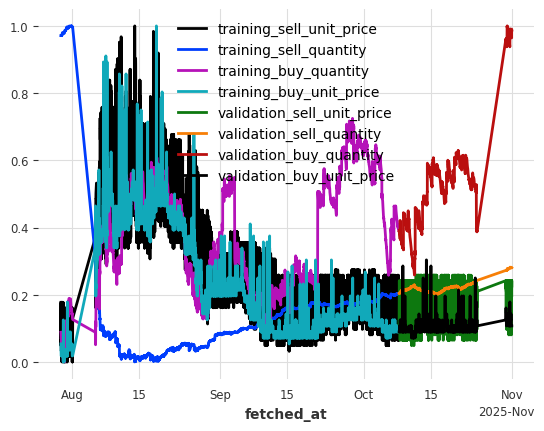

In [29]:
# Split the scaled series
train, val = series_scaled.split_after(0.75)

# Extract target and covariates from the SPLIT data, not the original series
train_target_series = train["sell_unit_price"]  # From the training split
train_covariate_series = train[["sell_quantity", "buy_quantity", "buy_unit_price"]]  # From training split

val_target_series = val["sell_unit_price"]  # From the validation split
val_covariate_series = val[["sell_quantity", "buy_quantity", "buy_unit_price"]]  # From validation split

train.plot(label="training")
val.plot(label="validation")



In [30]:
from darts.metrics import mape
from darts.models import XGBModel

model = XGBModel(
    lags=20,                     # use the last 12 observations as features
    lags_past_covariates=5,   # no past covariates by default
    lags_future_covariates=None, # no future covariates by default
    output_chunk_length=1,       # one‑step‑ahead forecasts
    n_estimators=200,            # number of boosting rounds
    max_depth=40,                 # tree depth
    learning_rate=0.1,           # shrinkage factor
    subsample=0.8,               # row sampling ratio
    colsample_bytree=0.8,        # column sampling ratio
    reg_alpha=0.0,               # L1 regularisation
    reg_lambda=0.0,              # L2 regularisation
    #early_stopping_rounds=20,   # stop if validation error doesn’t improve
    device="cuda:0" # this is broken
)
model.fit(train_target_series,
          past_covariates=train_covariate_series,
          val_series=val_target_series,
          val_past_covariates=val_covariate_series)



/home/lukas/Documents/Github/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [11:42:23] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/lukas/Documents/Github/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [11:42:23] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-rmse:0.12820
[1]	validation_0-rmse:0.11508
[2]	validation_0-rmse:0.10463
[3]	validation_0-rmse:0.09533
[4]	validation_0-rmse:0.08679
[5]	validation_0-rmse:0.07878
[6]	validation_0-rmse:0.07212
[7]	validation_0-rmse:0.06629
[8]	validation_0-rmse:0.06107
[9]	validation_0-rmse:0.05668
[10]	validation_0-rmse:0.05267
[11]	validation_0-rmse:0.04904
[12]	validation_0-rmse:0.04633
[13]	validation_0-rmse:0.04402
[14]	validation_0-rmse:0.04205
[15]	validation_0-rmse:0.04045
[16]	validation_0-rmse:0.03917
[17]	validation_0-rmse:0.03812
[18]	validation_0-rmse:0.03739
[19]	validation_0-rmse:0.03675
[20]	validation_0-rmse:0.03623
[21]	validation_0-rmse:0.03586
[22]	validation_0-rmse:0.03550
[23]	validation_0-rmse:0.03533
[24]	validation_0-rmse:0.03510
[25]	validation_0-rmse:0.03499
[26]	validation_0-rmse:0.03488
[27]	validation_0-rmse:0.03491
[28]	validation_0-rmse:0.03483
[29]	validation_0-rmse:0.03480
[30]	validation_0-rmse:0.03480
[31]	validation_0-rmse:0.03479
[32]	validation_0-

XGBModel(lags=20, lags_past_covariates=5, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, n_estimators=200, max_depth=40, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.0, reg_lambda=0.0, device=cuda:0)

In [35]:
# Concatenate training and validation covariates for prediction
# This provides the full range of past covariates needed
full_covariate_series = train_covariate_series.concatenate(val_covariate_series)
print(val_covariate_series.head())
print(val_covariate_series.tail())
# Now predict using the full covariate series
forecast = model.predict(
    n=len(val_target_series)-100,
    past_covariates=full_covariate_series,
)

error = mape(val_target_series, forecast)  # Note: use val_target_series, not val
print(f"MAPE: {error:.2f}%")


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


<TimeSeries (DataArray) (fetched_at: 5, component: 3, sample: 1)> Size: 120B
array([[[0.20370162],
        [0.39052451],
        [0.08928571]],

       [[0.20350465],
        [0.39050641],
        [0.08928571]],

       [[0.20346321],
        [0.3895496 ],
        [0.08928571]],

       [[0.20332508],
        [0.38842729],
        [0.08928571]],

       [[0.20323364],
        [0.38834454],
        [0.08928571]]])
Coordinates:
  * fetched_at  (fetched_at) datetime64[ns] 40B 2025-10-08T09:40:00 ... 2025-...
  * component   (component) object 24B 'sell_quantity' ... 'buy_unit_price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None
<TimeSeries (DataArray) (fetched_at: 5, component: 3, sample: 1)> Size: 120B
array([[[0.28019249],
        [0.98970657],
        [0.10714286]],

       [[0.28015865],
        [0.98959925],
        [0.10714286]],

       [[0.2801418 ],
        [0.98763651],
        [0.1071428

<Axes: xlabel='fetched_at'>

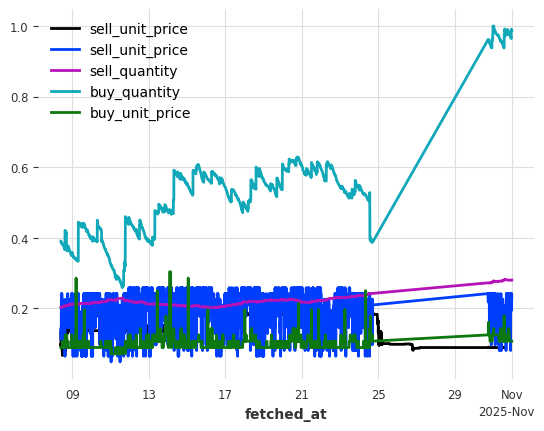

In [41]:
forecast.plot()
val.plot()

In [43]:
from darts.metrics import mape
from darts.models import XGBModel
from tqdm.notebook import tqdm
import mlflow
import os
from src.utils.mlflow_helper import setup_mlflow

setup_mlflow('gw2_xgboost', 'gw2_xgboost')
print(mlflow.get_tracking_uri())
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://localhost:9000"
os.environ['AWS_ACCESS_KEY_ID'] = 'minio'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'minio123'

best_mape = float('inf')
best_params = None

# Define hyperparameter ranges
lags_range = [24, 48, 72]
lags_past_covariates_range = [5, 10, 15]  # Added this parameter
n_estimators_range = [100, 200, 300]
max_depth_range = [20, 40, 60]
learning_rate_range = [0.05, 0.1, 0.2]
subsample_range = [0.6, 0.8, 1.0]
colsample_bytree_range = [0.6, 0.8, 1.0]

# Calculate total combinations
total_combinations = len(lags_range) * len(lags_past_covariates_range) * len(n_estimators_range) * len(max_depth_range) * \
                    len(learning_rate_range) * len(subsample_range) * len(colsample_bytree_range)

# Concatenate training and validation covariates for prediction
full_covariate_series = train_covariate_series.concatenate(val_covariate_series)

# Parent run for the hyperparameter search
with mlflow.start_run(run_name="XGBOOST_MULTIVARIATE_Hyperparameter_Search"):

    # Log search configuration
    mlflow.log_param("search_lags", str(lags_range))
    mlflow.log_param("search_lags_past_covariates", str(lags_past_covariates_range))
    mlflow.log_param("search_n_estimators", str(n_estimators_range))
    mlflow.log_param("search_max_depth", str(max_depth_range))
    mlflow.log_param("search_learning_rate", str(learning_rate_range))
    mlflow.log_param("search_subsample", str(subsample_range))
    mlflow.log_param("search_colsample_bytree", str(colsample_bytree_range))
    mlflow.log_param("total_combinations", total_combinations)

    # Create progress bar
    combination_count = 0
    for lags in lags_range:
        for lags_past_cov in lags_past_covariates_range:
            for n_estimators in n_estimators_range:
                for max_depth in max_depth_range:
                    for learning_rate in learning_rate_range:
                        for subsample in subsample_range:
                            for colsample_bytree in colsample_bytree_range:
                                combination_count += 1

                                print(f"Testing XGBModel {combination_count}/{total_combinations}: "
                                      f"lags={lags}, lags_past_cov={lags_past_cov}, n_est={n_estimators}, depth={max_depth}, "
                                      f"lr={learning_rate}, sub={subsample}, col={colsample_bytree}")

                                # Child run for each parameter combination
                                with mlflow.start_run(run_name=f"XGB_{lags}_{lags_past_cov}_{n_estimators}_{max_depth}_{learning_rate}_{subsample}_{colsample_bytree}", nested=True):
                                    # Log parameters
                                    mlflow.log_param("lags", lags)
                                    mlflow.log_param("lags_past_covariates", lags_past_cov)
                                    mlflow.log_param("n_estimators", n_estimators)
                                    mlflow.log_param("max_depth", max_depth)
                                    mlflow.log_param("learning_rate", learning_rate)
                                    mlflow.log_param("subsample", subsample)
                                    mlflow.log_param("colsample_bytree", colsample_bytree)
                                    mlflow.log_param("output_chunk_length", 1)
                                    mlflow.log_param("reg_alpha", 0.0)
                                    mlflow.log_param("reg_lambda", 0.0)
                                    mlflow.log_param("model_type", "XGBModel")

                                    try:
                                        # Train model
                                        model = XGBModel(
                                            lags=lags,
                                            lags_past_covariates=lags_past_cov,
                                            lags_future_covariates=None,
                                            output_chunk_length=1,
                                            n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            learning_rate=learning_rate,
                                            subsample=subsample,
                                            colsample_bytree=colsample_bytree,
                                            reg_alpha=0.0,
                                            reg_lambda=0.0,
                                            # device="cuda:0"  # commented out as is broken
                                        )

                                        # Fit with past covariates and validation data
                                        model.fit(train_target_series,
                                                  past_covariates=train_covariate_series,
                                                  val_series=val_target_series,
                                                  val_past_covariates=val_covariate_series)

                                        # Make predictions using full covariate series
                                        forecast = model.predict(
                                            n=len(val_target_series)-100,  # Using your original prediction length
                                            past_covariates=full_covariate_series,
                                        )

                                        error = mape(val_target_series, forecast)

                                        # Log metrics
                                        mlflow.log_metric("mape", error)
                                        mlflow.log_metric("mape_percentage", error)

                                        # Log model artifact
                                        mlflow.sklearn.log_model(model, "model")

                                        # Check if this is the best model so far
                                        if error < best_mape:
                                            best_mape = error
                                            best_params = {
                                                'lags': lags,
                                                'lags_past_covariates': lags_past_cov,
                                                'n_estimators': n_estimators,
                                                'max_depth': max_depth,
                                                'learning_rate': learning_rate,
                                                'subsample': subsample,
                                                'colsample_bytree': colsample_bytree
                                            }
                                            print(f"New best: {best_params} with MAPE: {error:.2f}%")

                                            # Log as best model in parent run
                                            mlflow.log_metric("best_mape", error)
                                            mlflow.log_param("best_lags", lags)
                                            mlflow.log_param("best_lags_past_covariates", lags_past_cov)
                                            mlflow.log_param("best_n_estimators", n_estimators)
                                            mlflow.log_param("best_max_depth", max_depth)
                                            mlflow.log_param("best_learning_rate", learning_rate)
                                            mlflow.log_param("best_subsample", subsample)
                                            mlflow.log_param("best_colsample_bytree", colsample_bytree)

                                    except Exception as e:
                                        # Log failed runs
                                        mlflow.log_param("status", "failed")
                                        mlflow.log_param("error", str(e))
                                        print(f"Failed XGBModel combination: {str(e)}")

    # Log final results in parent run
    mlflow.log_metric("final_best_mape", best_mape)
    mlflow.log_param("final_best_params", str(best_params))

    print(f"\nBest model: {best_params} with MAPE: {best_mape:.2f}%")


http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000
Testing XGBModel 1/2187: lags=24, lags_past_cov=5, n_est=100, depth=20, lr=0.05, sub=0.6, col=0.6
[0]	validation_0-rmse:0.13388
[1]	validation_0-rmse:0.12738
[2]	validation_0-rmse:0.12119
[3]	validation_0-rmse:0.11491
[4]	validation_0-rmse:0.10966
[5]	validation_0-rmse:0.10424
[6]	validation_0-rmse:0.09934
[7]	validation_0-rmse:0.09403
[8]	validation_0-rmse:0.08978
[9]	validation_0-rmse:0.08579
[10]	validation_0-rmse:0.08198
[11]	validation_0-rmse:0.07838
[12]	validation_0-rmse:0.07481
[13]	validation_0-rmse:0.07117
[14]	validation_0-rmse:0.06818
[15]	validation_0-rmse:0.06539
[16]	validation_0-rmse:0.06276
[17]	validation_0-rmse:0.06028
[18]	validation_0-rmse:0.05777
[19]	validation_0-rmse:0.05560
[20]	validation_0-rmse:0.05362
[21]	validation_0-rmse:0.05176
[22]	validation_0-rmse:0.05004
[23]	validation_0-rmse:0.04864
[24]	validation_0-rmse:0.04717
[25]	validation_0-rmse:0.04576
[26]	validation_0-rmse:0.04449
[

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
2025/11/11 11:49:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 11:49:11 WARNING mlflow.utils.requirements_utils: Found lz4 version (4.0.2+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==4.0.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/11 11:49:11 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+rocm7.1.0.git824e8c87) contains a local version label (+rocm7.1.0.git824e8c87). MLflow logged a pip requirem

New best: {'lags': 24, 'lags_past_covariates': 5, 'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.05, 'subsample': 0.6, 'colsample_bytree': 0.6} with MAPE: 32.21%
🏃 View run XGB_24_5_100_20_0.05_0.6_0.6 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4/runs/08ed4ca4fa314786abea3b73154cc27d
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4
Testing XGBModel 2/2187: lags=24, lags_past_cov=5, n_est=100, depth=20, lr=0.05, sub=0.6, col=0.8
[0]	validation_0-rmse:0.13479
[1]	validation_0-rmse:0.12839
[2]	validation_0-rmse:0.12228
[3]	validation_0-rmse:0.11596
[4]	validation_0-rmse:0.11046
[5]	validation_0-rmse:0.10506
[6]	validation_0-rmse:0.10007
[7]	validation_0-rmse:0.09535
[8]	validation_0-rmse:0.09079
[9]	validation_0-rmse:0.08663
[10]	validation_0-rmse:0.08276
[11]	validation_0-rmse:0.07909
[12]	validation_0-rmse:0.07565
[13]	validation_0-rmse:0.07214
[14]	validation_0-rmse

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
2025/11/11 11:49:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 11:49:23 WARNING mlflow.utils.requirements_utils: Found lz4 version (4.0.2+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==4.0.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/11 11:49:23 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+rocm7.1.0.git824e8c87) contains a local version label (+rocm7.1.0.git824e8c87). MLflow logged a pip requirem

New best: {'lags': 24, 'lags_past_covariates': 5, 'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.05, 'subsample': 0.6, 'colsample_bytree': 0.8} with MAPE: 26.67%
🏃 View run XGB_24_5_100_20_0.05_0.6_0.8 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4/runs/a7630898afb54ed2955ce9b2c31431c6
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4
Testing XGBModel 3/2187: lags=24, lags_past_cov=5, n_est=100, depth=20, lr=0.05, sub=0.6, col=1.0
[0]	validation_0-rmse:0.13467
[1]	validation_0-rmse:0.12823
[2]	validation_0-rmse:0.12197
[3]	validation_0-rmse:0.11550
[4]	validation_0-rmse:0.11002
[5]	validation_0-rmse:0.10486
[6]	validation_0-rmse:0.09998
[7]	validation_0-rmse:0.09521
[8]	validation_0-rmse:0.09090
[9]	validation_0-rmse:0.08689
[10]	validation_0-rmse:0.08289
[11]	validation_0-rmse:0.07923
[12]	validation_0-rmse:0.07569
[13]	validation_0-rmse:0.07242
[14]	validation_0-rmse

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
2025/11/11 11:49:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 11:49:34 WARNING mlflow.utils.requirements_utils: Found lz4 version (4.0.2+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==4.0.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/11 11:49:34 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+rocm7.1.0.git824e8c87) contains a local version label (+rocm7.1.0.git824e8c87). MLflow logged a pip requirem

New best: {'lags': 24, 'lags_past_covariates': 5, 'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.05, 'subsample': 0.6, 'colsample_bytree': 1.0} with MAPE: 25.65%
🏃 View run XGB_24_5_100_20_0.05_0.6_1.0 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4/runs/ff2dc4c99844451caac19ade78300c89
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4
Testing XGBModel 4/2187: lags=24, lags_past_cov=5, n_est=100, depth=20, lr=0.05, sub=0.8, col=0.6
[0]	validation_0-rmse:0.13393
[1]	validation_0-rmse:0.12741
[2]	validation_0-rmse:0.12125
[3]	validation_0-rmse:0.11553
[4]	validation_0-rmse:0.11008
[5]	validation_0-rmse:0.10483
[6]	validation_0-rmse:0.09991
[7]	validation_0-rmse:0.09537
[8]	validation_0-rmse:0.09099
[9]	validation_0-rmse:0.08670
[10]	validation_0-rmse:0.08201
[11]	validation_0-rmse:0.07835
[12]	validation_0-rmse:0.07484
[13]	validation_0-rmse:0.07137
[14]	validation_0-rmse

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
2025/11/11 11:49:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 11:49:47 WARNING mlflow.utils.requirements_utils: Found lz4 version (4.0.2+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==4.0.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/11 11:49:47 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+rocm7.1.0.git824e8c87) contains a local version label (+rocm7.1.0.git824e8c87). MLflow logged a pip requirem

🏃 View run XGB_24_5_100_20_0.05_0.8_0.6 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4/runs/2de417b9d6cd4363ad450733b390c604
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4
Testing XGBModel 5/2187: lags=24, lags_past_cov=5, n_est=100, depth=20, lr=0.05, sub=0.8, col=0.8
[0]	validation_0-rmse:0.13482
[1]	validation_0-rmse:0.12811
[2]	validation_0-rmse:0.12216
[3]	validation_0-rmse:0.11626
[4]	validation_0-rmse:0.11042
[5]	validation_0-rmse:0.10529
[6]	validation_0-rmse:0.10042
[7]	validation_0-rmse:0.09586
[8]	validation_0-rmse:0.09157
[9]	validation_0-rmse:0.08705
[10]	validation_0-rmse:0.08281
[11]	validation_0-rmse:0.07914
[12]	validation_0-rmse:0.07564
[13]	validation_0-rmse:0.07236
[14]	validation_0-rmse:0.06930
[15]	validation_0-rmse:0.06643
[16]	validation_0-rmse:0.06351
[17]	validation_0-rmse:0.06083
[18]	validation_0-rmse:0.05844
[19]	validation_0-rmse:0.05634
[20]	val

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
2025/11/11 11:49:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 11:50:00 WARNING mlflow.utils.requirements_utils: Found lz4 version (4.0.2+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==4.0.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/11 11:50:00 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+rocm7.1.0.git824e8c87) contains a local version label (+rocm7.1.0.git824e8c87). MLflow logged a pip requirem

🏃 View run XGB_24_5_100_20_0.05_0.8_0.8 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4/runs/dc35ade4a5ea4c90b9ee3e15a9a9812c
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4
Testing XGBModel 6/2187: lags=24, lags_past_cov=5, n_est=100, depth=20, lr=0.05, sub=0.8, col=1.0
[0]	validation_0-rmse:0.13492
[1]	validation_0-rmse:0.12831
[2]	validation_0-rmse:0.12211
[3]	validation_0-rmse:0.11618
[4]	validation_0-rmse:0.11073
[5]	validation_0-rmse:0.10549
[6]	validation_0-rmse:0.10055
[7]	validation_0-rmse:0.09592
[8]	validation_0-rmse:0.09162
[9]	validation_0-rmse:0.08708
[10]	validation_0-rmse:0.08311
[11]	validation_0-rmse:0.07930
[12]	validation_0-rmse:0.07582
[13]	validation_0-rmse:0.07233
[14]	validation_0-rmse:0.06927
[15]	validation_0-rmse:0.06638
[16]	validation_0-rmse:0.06341
[17]	validation_0-rmse:0.06086
[18]	validation_0-rmse:0.05853
[19]	validation_0-rmse:0.05639
[20]	val

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
2025/11/11 11:50:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 11:50:12 WARNING mlflow.utils.requirements_utils: Found lz4 version (4.0.2+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==4.0.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/11 11:50:12 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+rocm7.1.0.git824e8c87) contains a local version label (+rocm7.1.0.git824e8c87). MLflow logged a pip requirem

🏃 View run XGB_24_5_100_20_0.05_0.8_1.0 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4/runs/48c7d9473b114b779e683843697d4453
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4
Testing XGBModel 7/2187: lags=24, lags_past_cov=5, n_est=100, depth=20, lr=0.05, sub=1.0, col=0.6
[0]	validation_0-rmse:0.13482
[1]	validation_0-rmse:0.12789
[2]	validation_0-rmse:0.12183
[3]	validation_0-rmse:0.11584
[4]	validation_0-rmse:0.11030
[5]	validation_0-rmse:0.10517
[6]	validation_0-rmse:0.10028
[7]	validation_0-rmse:0.09523
[8]	validation_0-rmse:0.09081
[9]	validation_0-rmse:0.08650
[10]	validation_0-rmse:0.08258
[11]	validation_0-rmse:0.07885
[12]	validation_0-rmse:0.07509
[13]	validation_0-rmse:0.07185
[14]	validation_0-rmse:0.06876
[15]	validation_0-rmse:0.06582
[16]	validation_0-rmse:0.06307
[17]	validation_0-rmse:0.06023
[18]	validation_0-rmse:0.05782
[19]	validation_0-rmse:0.05559
[20]	val

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
2025/11/11 11:50:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 11:50:25 WARNING mlflow.utils.requirements_utils: Found lz4 version (4.0.2+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==4.0.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/11 11:50:25 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+rocm7.1.0.git824e8c87) contains a local version label (+rocm7.1.0.git824e8c87). MLflow logged a pip requirem

🏃 View run XGB_24_5_100_20_0.05_1.0_0.6 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4/runs/9c459994556d431c99d3ad135c97bed1
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4
Testing XGBModel 8/2187: lags=24, lags_past_cov=5, n_est=100, depth=20, lr=0.05, sub=1.0, col=0.8
[0]	validation_0-rmse:0.13506
[1]	validation_0-rmse:0.12809
[2]	validation_0-rmse:0.12165
[3]	validation_0-rmse:0.11559
[4]	validation_0-rmse:0.11018
[5]	validation_0-rmse:0.10472
[6]	validation_0-rmse:0.09994
[7]	validation_0-rmse:0.09535
[8]	validation_0-rmse:0.09039
[9]	validation_0-rmse:0.08611
[10]	validation_0-rmse:0.08218
[11]	validation_0-rmse:0.07835
[12]	validation_0-rmse:0.07484
[13]	validation_0-rmse:0.07130
[14]	validation_0-rmse:0.06816
[15]	validation_0-rmse:0.06533
[16]	validation_0-rmse:0.06259
[17]	validation_0-rmse:0.06009
[18]	validation_0-rmse:0.05781
[19]	validation_0-rmse:0.05563
[20]	val

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
2025/11/11 11:50:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 11:50:39 WARNING mlflow.utils.requirements_utils: Found lz4 version (4.0.2+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==4.0.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/11 11:50:39 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+rocm7.1.0.git824e8c87) contains a local version label (+rocm7.1.0.git824e8c87). MLflow logged a pip requirem

🏃 View run XGB_24_5_100_20_0.05_1.0_0.8 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4/runs/a52f1e106549439cb901f8aee43e2002
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4
Testing XGBModel 9/2187: lags=24, lags_past_cov=5, n_est=100, depth=20, lr=0.05, sub=1.0, col=1.0
[0]	validation_0-rmse:0.13501
[1]	validation_0-rmse:0.12865
[2]	validation_0-rmse:0.12263
[3]	validation_0-rmse:0.11684
[4]	validation_0-rmse:0.11095
[5]	validation_0-rmse:0.10565
[6]	validation_0-rmse:0.10063
[7]	validation_0-rmse:0.09577
[8]	validation_0-rmse:0.09145
[9]	validation_0-rmse:0.08708
[10]	validation_0-rmse:0.08312
[11]	validation_0-rmse:0.07942
[12]	validation_0-rmse:0.07603
[13]	validation_0-rmse:0.07269
[14]	validation_0-rmse:0.06968
[15]	validation_0-rmse:0.06672
[16]	validation_0-rmse:0.06402
[17]	validation_0-rmse:0.06161
[18]	validation_0-rmse:0.05938
[19]	validation_0-rmse:0.05739
[20]	val

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
2025/11/11 11:50:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 11:50:51 WARNING mlflow.utils.requirements_utils: Found lz4 version (4.0.2+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==4.0.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/11 11:50:51 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+rocm7.1.0.git824e8c87) contains a local version label (+rocm7.1.0.git824e8c87). MLflow logged a pip requirem

🏃 View run XGB_24_5_100_20_0.05_1.0_1.0 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4/runs/5f9f81cce4eb454d9b0ec32c401f9c4b
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4
Testing XGBModel 10/2187: lags=24, lags_past_cov=5, n_est=100, depth=20, lr=0.1, sub=0.6, col=0.6
[0]	validation_0-rmse:0.12618
[1]	validation_0-rmse:0.11445
[2]	validation_0-rmse:0.10338
[3]	validation_0-rmse:0.09364
[4]	validation_0-rmse:0.08523
[5]	validation_0-rmse:0.07768
[6]	validation_0-rmse:0.07079
[7]	validation_0-rmse:0.06461
[8]	validation_0-rmse:0.05961
[9]	validation_0-rmse:0.05503
[10]	validation_0-rmse:0.05083
[11]	validation_0-rmse:0.04750
[12]	validation_0-rmse:0.04484
[13]	validation_0-rmse:0.04246
[14]	validation_0-rmse:0.04062
[15]	validation_0-rmse:0.03902
[16]	validation_0-rmse:0.03784
[17]	validation_0-rmse:0.03669
[18]	validation_0-rmse:0.03596
[19]	validation_0-rmse:0.03541
[20]	val

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
2025/11/11 11:50:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 11:51:02 WARNING mlflow.utils.requirements_utils: Found lz4 version (4.0.2+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==4.0.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/11 11:51:02 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+rocm7.1.0.git824e8c87) contains a local version label (+rocm7.1.0.git824e8c87). MLflow logged a pip requirem

🏃 View run XGB_24_5_100_20_0.1_0.6_0.6 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4/runs/6520e203459e4e02a2511453527d056c
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4
Testing XGBModel 11/2187: lags=24, lags_past_cov=5, n_est=100, depth=20, lr=0.1, sub=0.6, col=0.8
[0]	validation_0-rmse:0.12791
[1]	validation_0-rmse:0.11595
[2]	validation_0-rmse:0.10518
[3]	validation_0-rmse:0.09456
[4]	validation_0-rmse:0.08600
[5]	validation_0-rmse:0.07815
[6]	validation_0-rmse:0.07100
[7]	validation_0-rmse:0.06504
[8]	validation_0-rmse:0.05949
[9]	validation_0-rmse:0.05467
[10]	validation_0-rmse:0.05072
[11]	validation_0-rmse:0.04745
[12]	validation_0-rmse:0.04466
[13]	validation_0-rmse:0.04136
[14]	validation_0-rmse:0.03948
[15]	validation_0-rmse:0.03800
[16]	validation_0-rmse:0.03672
[17]	validation_0-rmse:0.03569
[18]	validation_0-rmse:0.03486
[19]	validation_0-rmse:0.03428
[20]	vali

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
2025/11/11 11:51:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 11:51:13 WARNING mlflow.utils.requirements_utils: Found lz4 version (4.0.2+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==4.0.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/11 11:51:13 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+rocm7.1.0.git824e8c87) contains a local version label (+rocm7.1.0.git824e8c87). MLflow logged a pip requirem

🏃 View run XGB_24_5_100_20_0.1_0.6_0.8 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4/runs/a6bca17969a14ec8989f161a7d1d5e91
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4
Testing XGBModel 12/2187: lags=24, lags_past_cov=5, n_est=100, depth=20, lr=0.1, sub=0.6, col=1.0
[0]	validation_0-rmse:0.12768
[1]	validation_0-rmse:0.11555
[2]	validation_0-rmse:0.10471
[3]	validation_0-rmse:0.09404
[4]	validation_0-rmse:0.08543
[5]	validation_0-rmse:0.07790
[6]	validation_0-rmse:0.07134
[7]	validation_0-rmse:0.06522
[8]	validation_0-rmse:0.06005
[9]	validation_0-rmse:0.05550
[10]	validation_0-rmse:0.05131
[11]	validation_0-rmse:0.04804
[12]	validation_0-rmse:0.04516
[13]	validation_0-rmse:0.04239
[14]	validation_0-rmse:0.04050
[15]	validation_0-rmse:0.03886
[16]	validation_0-rmse:0.03744
[17]	validation_0-rmse:0.03630
[18]	validation_0-rmse:0.03559
[19]	validation_0-rmse:0.03496
[20]	vali

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
2025/11/11 11:51:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 11:51:24 WARNING mlflow.utils.requirements_utils: Found lz4 version (4.0.2+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==4.0.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/11 11:51:24 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+rocm7.1.0.git824e8c87) contains a local version label (+rocm7.1.0.git824e8c87). MLflow logged a pip requirem

🏃 View run XGB_24_5_100_20_0.1_0.6_1.0 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4/runs/6fda6ac8c8404c4e8589b6be9734e851
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4
Testing XGBModel 13/2187: lags=24, lags_past_cov=5, n_est=100, depth=20, lr=0.1, sub=0.8, col=0.6
[0]	validation_0-rmse:0.12626
[1]	validation_0-rmse:0.11276
[2]	validation_0-rmse:0.10184
[3]	validation_0-rmse:0.09225
[4]	validation_0-rmse:0.08378
[5]	validation_0-rmse:0.07561
[6]	validation_0-rmse:0.06900
[7]	validation_0-rmse:0.06324
[8]	validation_0-rmse:0.05855
[9]	validation_0-rmse:0.05396
[10]	validation_0-rmse:0.05015
[11]	validation_0-rmse:0.04702
[12]	validation_0-rmse:0.04439
[13]	validation_0-rmse:0.04200
[14]	validation_0-rmse:0.04028
[15]	validation_0-rmse:0.03885
[16]	validation_0-rmse:0.03782
[17]	validation_0-rmse:0.03697
[18]	validation_0-rmse:0.03620
[19]	validation_0-rmse:0.03584
[20]	vali

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
2025/11/11 11:51:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 11:51:41 WARNING mlflow.utils.requirements_utils: Found lz4 version (4.0.2+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==4.0.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/11 11:51:41 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+rocm7.1.0.git824e8c87) contains a local version label (+rocm7.1.0.git824e8c87). MLflow logged a pip requirem

🏃 View run XGB_24_5_100_20_0.1_0.8_0.6 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4/runs/796d7558e3b54d71bd6b8c7ae425355f
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4
Testing XGBModel 14/2187: lags=24, lags_past_cov=5, n_est=100, depth=20, lr=0.1, sub=0.8, col=0.8
[0]	validation_0-rmse:0.12797
[1]	validation_0-rmse:0.11542
[2]	validation_0-rmse:0.10469
[3]	validation_0-rmse:0.09478
[4]	validation_0-rmse:0.08628
[5]	validation_0-rmse:0.07846
[6]	validation_0-rmse:0.07179
[7]	validation_0-rmse:0.06483
[8]	validation_0-rmse:0.05941
[9]	validation_0-rmse:0.05493
[10]	validation_0-rmse:0.05088
[11]	validation_0-rmse:0.04765
[12]	validation_0-rmse:0.04481
[13]	validation_0-rmse:0.04252
[14]	validation_0-rmse:0.04062
[15]	validation_0-rmse:0.03898
[16]	validation_0-rmse:0.03766
[17]	validation_0-rmse:0.03673
[18]	validation_0-rmse:0.03589
[19]	validation_0-rmse:0.03523
[20]	vali

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
2025/11/11 11:51:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 11:51:59 WARNING mlflow.utils.requirements_utils: Found lz4 version (4.0.2+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==4.0.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/11 11:51:59 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+rocm7.1.0.git824e8c87) contains a local version label (+rocm7.1.0.git824e8c87). MLflow logged a pip requirem

🏃 View run XGB_24_5_100_20_0.1_0.8_0.8 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4/runs/f63d1e68896d43038b2e87f7eb71e35d
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4
Testing XGBModel 15/2187: lags=24, lags_past_cov=5, n_est=100, depth=20, lr=0.1, sub=0.8, col=1.0
[0]	validation_0-rmse:0.12815
[1]	validation_0-rmse:0.11530
[2]	validation_0-rmse:0.10445
[3]	validation_0-rmse:0.09411
[4]	validation_0-rmse:0.08547
[5]	validation_0-rmse:0.07715
[6]	validation_0-rmse:0.07051
[7]	validation_0-rmse:0.06461
[8]	validation_0-rmse:0.05939
[9]	validation_0-rmse:0.05490
[10]	validation_0-rmse:0.05106
[11]	validation_0-rmse:0.04774
[12]	validation_0-rmse:0.04492
[13]	validation_0-rmse:0.04230
[14]	validation_0-rmse:0.04036
[15]	validation_0-rmse:0.03873
[16]	validation_0-rmse:0.03754
[17]	validation_0-rmse:0.03660
[18]	validation_0-rmse:0.03580
[19]	validation_0-rmse:0.03518
[20]	vali

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
2025/11/11 11:52:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 11:52:15 WARNING mlflow.utils.requirements_utils: Found lz4 version (4.0.2+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==4.0.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/11 11:52:15 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+rocm7.1.0.git824e8c87) contains a local version label (+rocm7.1.0.git824e8c87). MLflow logged a pip requirem

🏃 View run XGB_24_5_100_20_0.1_0.8_1.0 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4/runs/4fb815ca4e834e928a59ab628aea8777
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4
Testing XGBModel 16/2187: lags=24, lags_past_cov=5, n_est=100, depth=20, lr=0.1, sub=1.0, col=0.6
[0]	validation_0-rmse:0.12799
[1]	validation_0-rmse:0.11493
[2]	validation_0-rmse:0.10423
[3]	validation_0-rmse:0.09432
[4]	validation_0-rmse:0.08550
[5]	validation_0-rmse:0.07699
[6]	validation_0-rmse:0.07007
[7]	validation_0-rmse:0.06405
[8]	validation_0-rmse:0.05899
[9]	validation_0-rmse:0.05472
[10]	validation_0-rmse:0.05107
[11]	validation_0-rmse:0.04784
[12]	validation_0-rmse:0.04518
[13]	validation_0-rmse:0.04294
[14]	validation_0-rmse:0.04115
[15]	validation_0-rmse:0.03995
[16]	validation_0-rmse:0.03888
[17]	validation_0-rmse:0.03790
[18]	validation_0-rmse:0.03777
[19]	validation_0-rmse:0.03718
[20]	vali

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
2025/11/11 11:52:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 11:52:31 WARNING mlflow.utils.requirements_utils: Found lz4 version (4.0.2+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==4.0.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/11 11:52:31 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+rocm7.1.0.git824e8c87) contains a local version label (+rocm7.1.0.git824e8c87). MLflow logged a pip requirem

🏃 View run XGB_24_5_100_20_0.1_1.0_0.6 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4/runs/25941d8a61d14d5781cfac5760520e7c
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4
Testing XGBModel 17/2187: lags=24, lags_past_cov=5, n_est=100, depth=20, lr=0.1, sub=1.0, col=0.8
[0]	validation_0-rmse:0.12843
[1]	validation_0-rmse:0.11534
[2]	validation_0-rmse:0.10389
[3]	validation_0-rmse:0.09407
[4]	validation_0-rmse:0.08511
[5]	validation_0-rmse:0.07755
[6]	validation_0-rmse:0.07098
[7]	validation_0-rmse:0.06496
[8]	validation_0-rmse:0.05986
[9]	validation_0-rmse:0.05514
[10]	validation_0-rmse:0.05139
[11]	validation_0-rmse:0.04774
[12]	validation_0-rmse:0.04501
[13]	validation_0-rmse:0.04294
[14]	validation_0-rmse:0.04119
[15]	validation_0-rmse:0.03973
[16]	validation_0-rmse:0.03871
[17]	validation_0-rmse:0.03780
[18]	validation_0-rmse:0.03712
[19]	validation_0-rmse:0.03654
[20]	vali

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
2025/11/11 11:52:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 11:52:48 WARNING mlflow.utils.requirements_utils: Found lz4 version (4.0.2+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==4.0.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/11 11:52:48 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+rocm7.1.0.git824e8c87) contains a local version label (+rocm7.1.0.git824e8c87). MLflow logged a pip requirem

🏃 View run XGB_24_5_100_20_0.1_1.0_0.8 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4/runs/24c0a8e227ed42658a7238cf91777556
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4
Testing XGBModel 18/2187: lags=24, lags_past_cov=5, n_est=100, depth=20, lr=0.1, sub=1.0, col=1.0
[0]	validation_0-rmse:0.12834
[1]	validation_0-rmse:0.11627
[2]	validation_0-rmse:0.10476
[3]	validation_0-rmse:0.09452
[4]	validation_0-rmse:0.08543
[5]	validation_0-rmse:0.07758
[6]	validation_0-rmse:0.07085
[7]	validation_0-rmse:0.06494
[8]	validation_0-rmse:0.05992
[9]	validation_0-rmse:0.05563
[10]	validation_0-rmse:0.05210
[11]	validation_0-rmse:0.04908
[12]	validation_0-rmse:0.04658
[13]	validation_0-rmse:0.04450
[14]	validation_0-rmse:0.04280
[15]	validation_0-rmse:0.04142
[16]	validation_0-rmse:0.04031
[17]	validation_0-rmse:0.03945
[18]	validation_0-rmse:0.03874
[19]	validation_0-rmse:0.03814
[20]	vali

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
2025/11/11 11:52:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 11:53:03 WARNING mlflow.utils.requirements_utils: Found lz4 version (4.0.2+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==4.0.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/11 11:53:03 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+rocm7.1.0.git824e8c87) contains a local version label (+rocm7.1.0.git824e8c87). MLflow logged a pip requirem

🏃 View run XGB_24_5_100_20_0.1_1.0_1.0 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4/runs/2225b762489d4e0a95d6444e7032d964
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4
Testing XGBModel 19/2187: lags=24, lags_past_cov=5, n_est=100, depth=20, lr=0.2, sub=0.6, col=0.6
[0]	validation_0-rmse:0.11130
[1]	validation_0-rmse:0.08931
[2]	validation_0-rmse:0.07357
[3]	validation_0-rmse:0.06104
[4]	validation_0-rmse:0.05223
[5]	validation_0-rmse:0.04609
[6]	validation_0-rmse:0.04260
[7]	validation_0-rmse:0.04174
[8]	validation_0-rmse:0.04076
[9]	validation_0-rmse:0.04145
[10]	validation_0-rmse:0.04374
[11]	validation_0-rmse:0.04393
[12]	validation_0-rmse:0.04385
[13]	validation_0-rmse:0.04466
[14]	validation_0-rmse:0.04584
[15]	validation_0-rmse:0.04616
[16]	validation_0-rmse:0.04655
[17]	validation_0-rmse:0.04659
[18]	validation_0-rmse:0.04696
[19]	validation_0-rmse:0.04675
[20]	vali

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
2025/11/11 11:53:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 11:53:17 WARNING mlflow.utils.requirements_utils: Found lz4 version (4.0.2+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==4.0.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/11 11:53:17 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+rocm7.1.0.git824e8c87) contains a local version label (+rocm7.1.0.git824e8c87). MLflow logged a pip requirem

🏃 View run XGB_24_5_100_20_0.2_0.6_0.6 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4/runs/2056c36a19554de0a5e5fdb03f136b90
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4
Testing XGBModel 20/2187: lags=24, lags_past_cov=5, n_est=100, depth=20, lr=0.2, sub=0.6, col=0.8
[0]	validation_0-rmse:0.11431
[1]	validation_0-rmse:0.09298
[2]	validation_0-rmse:0.07622
[3]	validation_0-rmse:0.06199
[4]	validation_0-rmse:0.05294
[5]	validation_0-rmse:0.04574
[6]	validation_0-rmse:0.04170
[7]	validation_0-rmse:0.03876
[8]	validation_0-rmse:0.03705
[9]	validation_0-rmse:0.03576
[10]	validation_0-rmse:0.03515
[11]	validation_0-rmse:0.03480
[12]	validation_0-rmse:0.03472
[13]	validation_0-rmse:0.03452
[14]	validation_0-rmse:0.03472
[15]	validation_0-rmse:0.03478
[16]	validation_0-rmse:0.03486
[17]	validation_0-rmse:0.03490
[18]	validation_0-rmse:0.03498
[19]	validation_0-rmse:0.03503
[20]	vali

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
2025/11/11 11:53:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 11:53:31 WARNING mlflow.utils.requirements_utils: Found lz4 version (4.0.2+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==4.0.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/11 11:53:31 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+rocm7.1.0.git824e8c87) contains a local version label (+rocm7.1.0.git824e8c87). MLflow logged a pip requirem

🏃 View run XGB_24_5_100_20_0.2_0.6_0.8 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4/runs/9f0034273f6c44f1b3b7220335221feb
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4
Testing XGBModel 21/2187: lags=24, lags_past_cov=5, n_est=100, depth=20, lr=0.2, sub=0.6, col=1.0
[0]	validation_0-rmse:0.11388
[1]	validation_0-rmse:0.09278
[2]	validation_0-rmse:0.07625
[3]	validation_0-rmse:0.06359
[4]	validation_0-rmse:0.05426
[5]	validation_0-rmse:0.04736
[6]	validation_0-rmse:0.04245
[7]	validation_0-rmse:0.03908
[8]	validation_0-rmse:0.03685
[9]	validation_0-rmse:0.03545
[10]	validation_0-rmse:0.03478
[11]	validation_0-rmse:0.03451
[12]	validation_0-rmse:0.03439
[13]	validation_0-rmse:0.03463
[14]	validation_0-rmse:0.03468
[15]	validation_0-rmse:0.03464
[16]	validation_0-rmse:0.03468
[17]	validation_0-rmse:0.03443
[18]	validation_0-rmse:0.03452
[19]	validation_0-rmse:0.03456
[20]	vali

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
2025/11/11 11:53:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 11:53:44 WARNING mlflow.utils.requirements_utils: Found lz4 version (4.0.2+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==4.0.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/11 11:53:44 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+rocm7.1.0.git824e8c87) contains a local version label (+rocm7.1.0.git824e8c87). MLflow logged a pip requirem

🏃 View run XGB_24_5_100_20_0.2_0.6_1.0 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4/runs/74246b8c17a946ec9f377e1afdaf3442
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4
Testing XGBModel 22/2187: lags=24, lags_past_cov=5, n_est=100, depth=20, lr=0.2, sub=0.8, col=0.6
🏃 View run XGB_24_5_100_20_0.2_0.8_0.6 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4/runs/2f0d91ed4c4d48bba119ab66fe37ea12
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4
🏃 View run XGBOOST_MULTIVARIATE_Hyperparameter_Search at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4/runs/80f4cbd1f5894a4f81c2a4e45244b6c3
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/4


KeyboardInterrupt: 

In [ ]:
from darts.models import NaiveDrift, VARIMA
from darts.metrics import mape

def eval_model(model):

    model.fit(train)
    forecast = model.predict(len(val))
    print(f"model {model} obtains MAPE: {mape(val, forecast):.2f}%")


eval_model(NaiveDrift())
eval_model(VARIMA())
eval_model(VARIMA(p=3, d=1, q=2))